In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm

mpl.rcdefaults()
mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
mpl.rcParams.update(mpl_config)

In [2]:
# Pour directement importer les bonnes sessions

sheet_name = "HERCULE"  # Nom de la feuille
headstage = 0

sheet_id = "1sFatSTXO0j3OONKstz7YN-mM04kNMjk_r7zo951yicU"

url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(url)

filtered_sessions = df[(df['use'] == 'yes') &(df['type'].isin(['playback_block', 'playback']))]    # dans 'type' tu mets le style de sessions que tu veux regarder parmi : 'playback' et 'playback_block'
#filtered_sessions = df[(df['use'] == 'yes') &(df['type'].isin(['playback']))] 
sessions = filtered_sessions['session']
sessions_type = filtered_sessions['type']

In [2]:
def compare_diff(x):
    """
    Given a 1D array x, return an array y of same length with:
        y[i] =  1 if x[i] > x[i-1]
        y[i] = -1 if x[i] < x[i-1]
        y[i] =  0 if x[i] == x[i-1]
    y[0] is set to 0 by convention.
    """
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=int)
    diff = np.diff(x)
    
    y[1:] = np.where(diff > 0, 1, np.where(diff < 0, -1, 0))
    
    return y


### Analysis A1

In [621]:
os.chdir('/Volumes/LaCie')


files_hercule =['HERCULE_20250528_SESSION_01/headstage_0/','HERCULE_20250602_SESSION_00/headstage_0/',\
       'HERCULE_20250603_SESSION_01/headstage_0/','HERCULE_20250604_SESSION_00/headstage_0/',\
      'HERCULE_20250604_SESSION_01/headstage_0/','HERCULE_20250605_SESSION_00/headstage_0/',\
      'HERCULE_20250605_SESSION_01/headstage_0/','HERCULE_20250606_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_00/headstage_0/',\
      'HERCULE_20250612_SESSION_02/headstage_0/','HERCULE_20250616_SESSION_01/headstage_0/']


for i in range(len(files_hercule)) :
    files_hercule[i]='HERCULE/' + files_hercule[i]

files_napoleon  = [f for f in os.listdir('NAPOLEON/')]
for i in range(len(files_napoleon)) :
    files_napoleon[i]='NAPOLEON/' + files_napoleon[i] + '/headstage_1/'
    
files = files_hercule + files_napoleon


n_data_s = []
f_data_s = []
for file in tqdm(files) :
    try :
        n_data = np.load(file+'data_0.005.npy')
        f_data = np.load(file+'features_0.005.npy',allow_pickle=True)
        gc = np.load(file+'good_clusters.npy')
        
        
        f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}
    
        for item in f_data:
            for key, value in item.items():
                f_data_dict[key].append(value)

        f_data = pd.DataFrame(f_data_dict)
        f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
        f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())
        
        n_data = n_data[gc,:].astype(float)
        #n_data=n_data.astype(float)
    
        n_data_s.append(n_data)
        f_data_s.append(f_data)
        
    except :
        print('Error when building dataframe for file :' + str(file))

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/49 [00:00<?, ?it/s]

Error when building dataframe for file :NAPOLEON/NAPOLEON_20241202_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241212_SESSION_02/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241213_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20241220_SESSION_01/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250127_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_00/headstage_1/
Error when building dataframe for file :NAPOLEON/NAPOLEON_20250217_SESSION_01/headstage_1/


In [622]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_s))) :
    n_data_smooth = gaussian_filter(n_data_s[i],sigma=10,axes=1)
    n_data_s[i] = n_data_smooth

  0%|          | 0/42 [00:00<?, ?it/s]

In [841]:
with open("Save/hercule_a1", "wb") as fp:   #Pickling
    pickle.dump(n_data_s[:len(files_hercule)], fp)

with open("Save/napoleon_a1", "wb") as fp: 
    pickle.dump(n_data_s[len(files_hercule):], fp)

with open("Save/hercule_features", "wb") as fp:
    pickle.dump(f_data_s[:len(files_hercule)], fp)

with open("Save/napoleon_features", "wb") as fp:
    pickle.dump(f_data_s[len(files_hercule):], fp)

with open("Save/h&n_a1", "wb") as fp:
    pickle.dump(n_data_s, fp)

with open("Save/h&n_features", "wb") as fp:
    pickle.dump(f_data_s, fp)

In [3]:
with open("Save/h&n_a1", "rb") as fp:
    n_data_s = pickle.load(fp)

with open("Save/h&n_features", "rb") as fp:
    f_data_s = pickle.load(fp)

In [4]:
w_size = 100
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(window_size/3))
        end = min(total_len, idx + int(2*window_size/3)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > 0: # window_size//5:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def compute_mean_trajectories(trajectories, vicinity_indices, event_values):
    """
    Computes the mean trajectory in the vicinity of events grouped by event label.

    Parameters:
        trajectories (np.ndarray): [T, D] array of trajectory over time.
        vicinity_indices (np.ndarray): [N_events, window_size] of indices for each event.
        event_values (np.ndarray): [N_events] of numerical event labels (can be float or int).

    Returns:
        dict: {label: mean_trajectory} where mean_trajectory is [window_size, D]
    """
    unique_labels = np.unique(event_values)
    result = {}

    for label in unique_labels:
        # Find all events with this label
        label_mask = event_values == label
        label_indices = vicinity_indices[label_mask]

        valid_segments = []
        for inds in label_indices:
            # Filter out -1 (padding from earlier step)
            valid_mask = inds >= 0
            if np.any(valid_mask):
                valid_inds = inds[valid_mask]
                segment = trajectories[valid_inds]
                # Pad with NaNs if needed (for edge events)
                if segment.shape[0] < inds.shape[0]:
                    padded = np.full((inds.shape[0], trajectories.shape[1]), np.nan)
                    padded[valid_mask] = segment
                    segment = padded
                valid_segments.append(segment)

        if valid_segments:
            mean_traj = np.nanmean(np.stack(valid_segments), axis=0)
            result[label] = mean_traj

    return result

In [5]:
f_min, f_max = 600, 6000
all_traj_track_p, all_traj_track_m = [], []
all_traj_pb_p, all_traj_pb_m, all_traj_pb_mock = [], [], []

def process_traj(data, event_idx, event_freq):
    """Compute and filter mean trajectories by frequency range."""
    m_traj = compute_mean_trajectories(data.T, event_idx, event_freq)
    return {k: v for k, v in m_traj.items() if f_min <= k <= f_max}

for n_data, f_data in zip(n_data_s, f_data_s):
    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    mock = f_data['Mock_frequency'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition = f_data['Condition'].to_numpy()

    trigger_map = {
        'track_p': triggers * (condition == 0) * (direc == 1),
        'track_m': triggers * (condition == 0) * (direc == -1),
        'pb_p':    triggers * (condition == 1) * (direc == 1),
        'pb_m':    triggers * (condition == 1) * (direc == -1),
        'pb_mock': triggers_mock * (condition == 1),
    }

    event_idx_map = {k: get_event_vicinity(v, w_size) for k, v in trigger_map.items()}
    freq_map = {
        'track_p': freq[event_idx_map['track_p'][:, w_size - 1]],
        'track_m': freq[event_idx_map['track_m'][:, w_size - 1]],
        'pb_p':    freq[event_idx_map['pb_p'][:, w_size - 1]],
        'pb_m':    freq[event_idx_map['pb_m'][:, w_size - 1]],
        'pb_mock': mock[event_idx_map['pb_mock'][:, w_size - 1]],
    }

    all_traj_track_p.append(process_traj(n_data, event_idx_map['track_p'], freq_map['track_p']))
    all_traj_track_m.append(process_traj(n_data, event_idx_map['track_m'], freq_map['track_m']))
    all_traj_pb_p.append(process_traj(n_data, event_idx_map['pb_p'], freq_map['pb_p']))
    all_traj_pb_m.append(process_traj(n_data, event_idx_map['pb_m'], freq_map['pb_m']))
    all_traj_pb_mock.append(process_traj(n_data, event_idx_map['pb_mock'], freq_map['pb_mock']))


In [758]:
def pseudo_trajectories(mean_traj_dicts):
    """
    Concatenate mean trajectories across sessions by label along the feature axis.

    Parameters:
        mean_traj_dicts (list of dict): Each dict maps label to [T, D] mean trajectory arrays.

    Returns:
        pd.DataFrame: with columns ['trajectory', 'label'].
                     'trajectory' is a [T, D_total] array for each label.
    """
    grouped_traj = {key:[] for key in mean_traj_dicts[0].keys()}

    # Group all trajectories by label
    for session_dict in mean_traj_dicts:
        for label, traj in session_dict.items():
            grouped_traj[label].append(traj)

    # Concatenate along columns (axis=1)
    data = []
    for label, traj_list in grouped_traj.items():
        concatenated = np.concatenate(traj_list, axis=1)  # shape: [T, D_total]
        data.append((concatenated, label))

    # Build the DataFrame
    df = pd.DataFrame(data, columns=["trajectory", "label"])
    return df


traj_df_track_p, traj_df_track_m = pseudo_trajectories(all_traj_track_p), pseudo_trajectories(all_traj_track_m)
traj_df_pb_p, traj_df_pb_m = pseudo_trajectories(all_traj_pb_p), pseudo_trajectories(all_traj_pb_m)

In [ ]:
from sklearn.decomposition import PCA

# Stack trajectories
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory']),
]

# Concatenate all trajectory matrices
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_samples, n_time, n_features = traj_mat_all.shape
traj_mat_flat = traj_mat_all.reshape(n_samples * n_time, n_features)

# PCA
n_comp = 10
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

# Reshape back to original time structure
traj_PC_all = traj_PC_all_flat.reshape(n_samples, n_time, n_comp)

# Split back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]


In [760]:
with open("Save/PCA_a1_widefreq", "wb") as fp:   #Pickling
    pickle.dump(pca_all, fp)

In [823]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, hsv_to_rgb
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import splprep, splev, interp1d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection


def create_white_to_color_colormaps(n_colors=16):
    """
    Create a list of colormaps transitioning from white to evenly spaced colors on the HSV wheel.

    Parameters:
        n_colors (int): Number of distinct colormaps to generate.

    Returns:
        list of LinearSegmentedColormap: List of custom colormaps.
    """
    colormaps = []
    for i in range(n_colors):
        hue = i / n_colors  # evenly spaced hue
        color = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # pure hue at full saturation/value
        cmap = mcolors.LinearSegmentedColormap.from_list(
            f'white_to_color_{i}', [(1, 1, 1), color], N=256
        )
        colormaps.append(cmap)
    return colormaps
    
def get_hsv_colors(n_colors=16):
    """Generate evenly spaced HSV colors converted to RGB."""
    return [mcolors.hsv_to_rgb([i / n_colors, 1.0, 1.0]) for i in range(n_colors)]

def add_phase_gradient_legend(ax, colors, tick_labels=None, vertical=False):
    """
    Draws a phase gradient legend on an existing axis.

    Parameters:
        ax (matplotlib.axes.Axes): Axis on which to draw the gradient.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): Optional list of tick labels (must match len(colors)).
        vertical (bool): If True, draw vertically instead of horizontally.
    """
    n = len(colors)
    steps = 32  # Resolution per segment for smoothness
    cmap = mcolors.LinearSegmentedColormap.from_list("phase_gradient", colors)

    if vertical:
        gradient = np.linspace(0, 1, n * steps).reshape(-1, 1)
        ax.imshow(gradient, aspect='auto', cmap=cmap, origin='lower')
        ax.set_xticks([])
        tick_positions = np.linspace(0, gradient.shape[0] - 1, n)
        ax.set_yticks(tick_positions)
        if tick_labels:
            ax.set_yticklabels(tick_labels)
        else:
            ax.set_yticklabels([f"{i}" for i in range(n)])
    else:
        gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap=cmap)
        ax.set_yticks([])
        tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
        ax.set_xticks(tick_positions)
        if len(tick_labels)>0:
            ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        else:
            ax.set_xticklabels([f"{i}" for i in range(n)])
    
    ax.tick_params(axis='both', length=0)

def add_inset_phase_legend(main_ax, colors, tick_labels=None, location='upper right', size="30%", pad=0.05):
    """
    Adds a compact phase gradient legend to an existing axis using an inset.

    Parameters:
        main_ax (matplotlib.axes.Axes): The main axis to attach the legend to.
        colors (list): List of RGB colors defining the gradient.
        tick_labels (list): List of tick labels for each color.
        location (str): Location inside main_ax to place the inset ('lower right', 'upper left', etc.).
        size (str or tuple): Size of the inset axes, e.g., '30%' or (width, height).
        pad (float): Padding from edge of the main_ax.
    """
    n = len(colors)
    steps = 32
    gradient = np.linspace(0, 1, n * steps).reshape(1, -1)
    cmap = LinearSegmentedColormap.from_list("phase_gradient", colors)

    # Create inset axis
    inset_ax = inset_axes(main_ax, width=size, height="5%", loc=location, borderpad=pad)
    inset_ax.imshow(gradient, aspect='auto', cmap=cmap)
    inset_ax.set_yticks([])

    tick_positions = np.linspace(0, gradient.shape[1] - 1, n)
    inset_ax.set_xticks(tick_positions)

    if len(tick_labels)>0:
        inset_ax.set_xticklabels(tick_labels, rotation=45, ha='right',fontsize=12)
        inset_ax.set_title('Frequency change',fontsize=15)
    else:
        inset_ax.set_xticklabels([str(i) for i in range(n)])

    inset_ax.tick_params(axis='x', length=0)
    
def draw_traj(traj,ax,cmap,three_d=False) :
    t_length=len(traj)
    for i in range(t_length-1):
        color = cmap(0.1+0.9*i / (t_length - 1))
        if three_d :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],traj[i:i+2,2],color=color,linewidth=5)
        else :
            ax.plot(traj[i:i+2,0],traj[i:i+2,1],color=color,linewidth=4)

def plot_gradient_curve(points, base_colors, ax, n_interp=200, smooth=0, marker='o', lw=2, alpha=0.8):
    """
    Fit a smooth curve through points (2D or 3D) and color it using HSV/RGB base colors.

    Parameters
    ----------
    points : array-like, shape (N, 2) or (N, 3)
        Input coordinates of the curve anchor points.
    base_colors : array-like, shape (N, 3)
        RGB colors for each anchor point.
    ax : matplotlib Axes or Axes3D
        Axis to plot on.
    n_interp : int
        Number of interpolation points for smoothness.
    smooth : float
        Spline smoothing factor (0 = exact fit).
    marker : str
        Marker for original points.
    lw : float
        Line width.
    alpha : float
        Transparency for the gradient line.
    """
    points = np.asarray(points)
    base_colors = np.asarray(base_colors)
    N, dim = points.shape
    if dim not in (2, 3):
        raise ValueError("Points must be either 2D or 3D.")

    # Parameterize the spline by normalized arc length
    distances = np.linalg.norm(np.diff(points, axis=0), axis=1)
    cumulative_dist = np.insert(np.cumsum(distances), 0, 0)
    cumulative_dist /= cumulative_dist[-1] if cumulative_dist[-1] != 0 else 1.0

    # Fit spline in each dimension
    tck, u = splprep(points.T, s=smooth, k=min(3, N-1))
    u_interp = np.linspace(0, 1, n_interp)
    coords_interp = splev(u_interp, tck)
    curve_points = np.stack(coords_interp, axis=1)

    # Interpolate colors across u
    interp_r = interp1d(u, base_colors[:, 0], kind='linear', fill_value="extrapolate")
    interp_g = interp1d(u, base_colors[:, 1], kind='linear', fill_value="extrapolate")
    interp_b = interp1d(u, base_colors[:, 2], kind='linear', fill_value="extrapolate")
    rgb_interp = np.stack([
        interp_r(u_interp),
        interp_g(u_interp),
        interp_b(u_interp)
    ], axis=1)

    # Build segments for gradient
    segments = np.stack([curve_points[:-1], curve_points[1:]], axis=1)
    segment_colors = rgb_interp[:-1]

    if dim == 2:
        lc = LineCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection(lc)
        ax.scatter(points[:, 0], points[:, 1], c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)
    else:
        lc = Line3DCollection(segments, colors=segment_colors, linewidths=lw, alpha=alpha)
        ax.add_collection3d(lc)
        ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                   c=base_colors, edgecolor='k', marker=marker, s=40, zorder=3)


Text(0, 0.5, 'PC2')

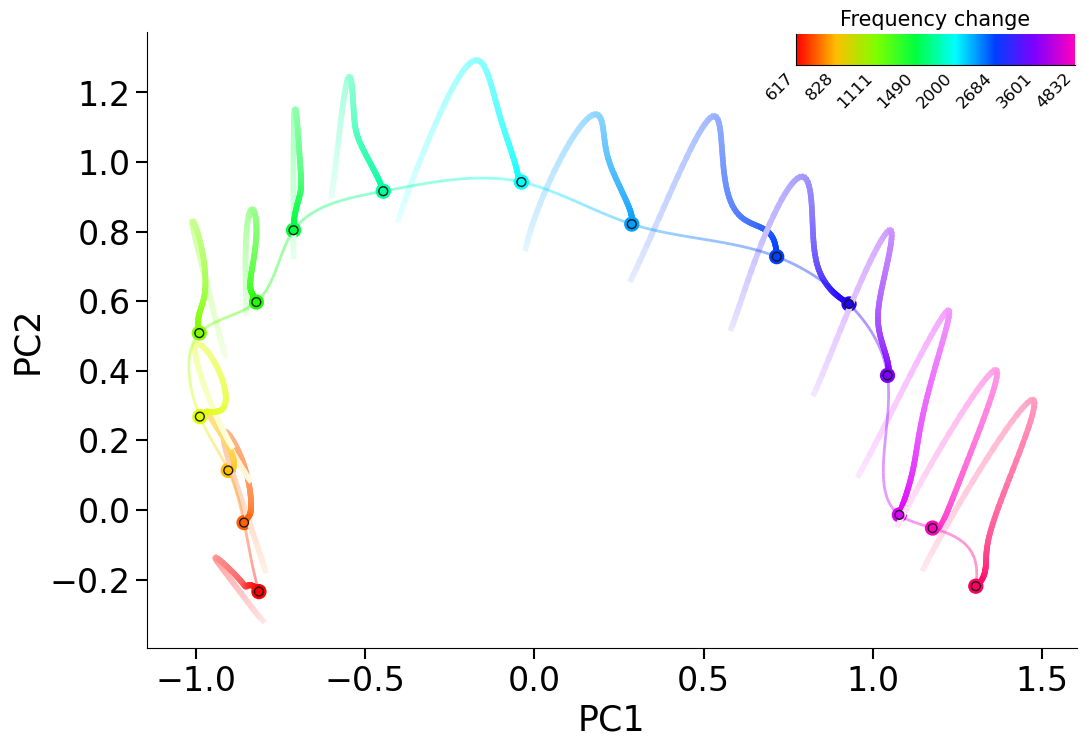

In [762]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_track_p

nb_times = len(traj_toplot[0])

start_time = int(nb_times*0.2)
stop_time = int(nb_times*0.9)

for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][start_time:stop_time,:2],ax,cmaps[i])

    
colors = get_hsv_colors(len(traj_toplot))



ax.scatter(traj_toplot[:,stop_time,0],traj_toplot[:,stop_time,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,stop_time,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
#plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

## Comparing Tracking vs Playback representations

Text(0, 0.5, 'PC2')

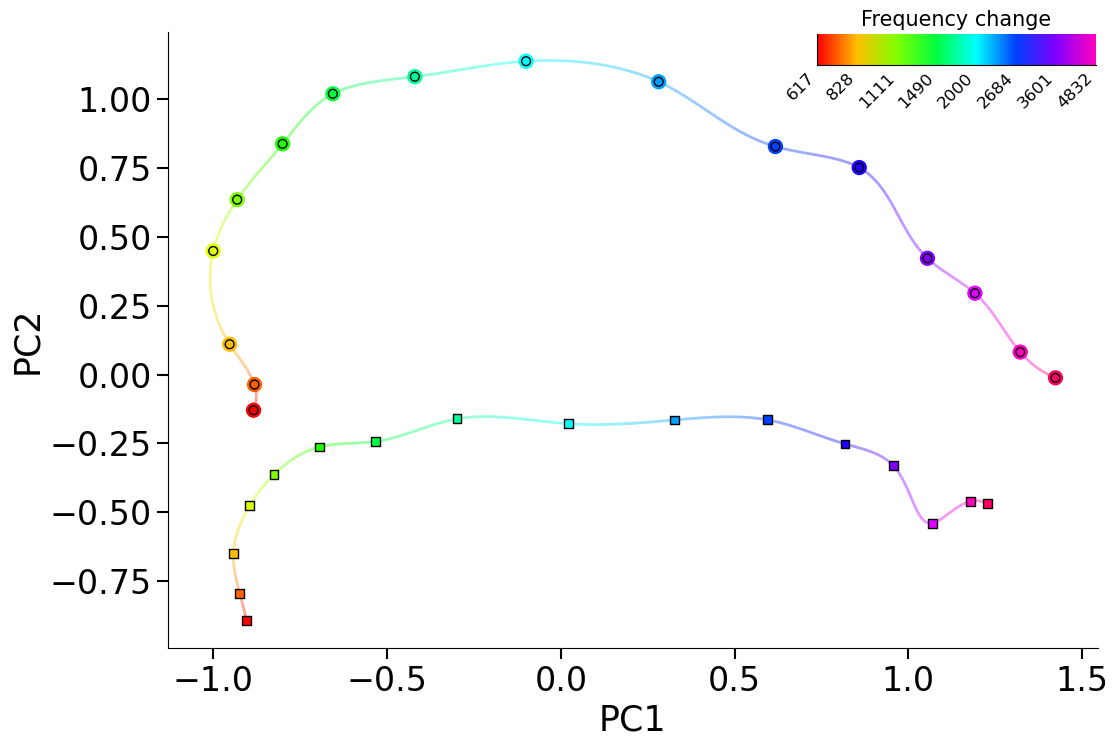

In [368]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_pb = (traj_PC_pb_p + traj_PC_pb_m)/2
traj_track = (traj_PC_track_p + traj_PC_track_m)/2
"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][:,:2],ax,cmaps[i])
"""
colors = get_hsv_colors(len(traj_pb))
nb_times = len(traj_pb[0])

ax.scatter(traj_track[:,nb_times//3,0],traj_track[:,nb_times//3,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_track[:,nb_times//3,:2],colors, ax)

plot_gradient_curve(traj_pb[:,nb_times//3,:2],colors, ax, marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

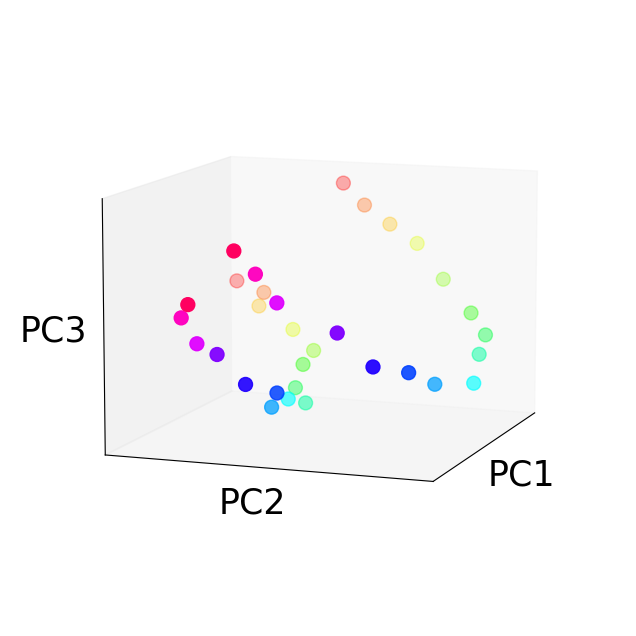

In [763]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()

traj_PC_track = (traj_PC_track_p + traj_PC_track_m)/2
traj_PC_pb = (traj_PC_pb_p + traj_PC_pb_m)/2

ax.scatter(traj_PC_track[:,-1,0],traj_PC_track[:,-1,1],traj_PC_track[:,-1,2],c=colors,s=100)
ax.scatter(traj_PC_pb[:,-1,0],traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=20, elev=10)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

In [514]:
def vec_alignement(n1,n2) :
    n1 /= np.linalg.norm(n1)
    n2 /= np.linalg.norm(n2)
    
    # Dot product clipped to [-1, 1] for numerical safety
    dot = np.clip(np.dot(n1, n2), -1.0, 1.0)
    
    theta = np.arccos(dot)
    theta = min(theta, np.pi - theta)

    return theta*180/np.pi


pca_2d_track = PCA(n_components=2)
pca_2d_pb = PCA(n_components=2)

n_freq = len(traj_PC_track)

tonotopy_alignement = []
ctx_n1 = []
ctx_n2 = []
for b in range(100) :
    track_boot = traj_PC_track[np.random.choice(range(n_freq),n_freq,replace=True),-1,:3]
    pb_boot = traj_PC_pb[np.random.choice(range(n_freq),n_freq,replace=True),-1,:3]
    
    pca_2d_track.fit(track_boot)
    pca_2d_pb.fit(pb_boot)

    ctx_axis = np.mean(track_boot,axis=0) - np.mean(pb_boot,axis=0)

    n1 = np.cross(pca_2d_track.components_[0], pca_2d_track.components_[1])
    n2 = np.cross(pca_2d_pb.components_[0], pca_2d_pb.components_[1])
    
    tonotopy_alignement.append(vec_alignement(n1,n2))
    ctx_n1.append(vec_alignement(n1,ctx_axis))
    ctx_n2.append(vec_alignement(n2,ctx_axis))

alignement_permu = [vec_alignement(np.random.normal(size = 3),np.random.normal(size = 3)) for _ in range(1000)]

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/3306040458.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Value", y="Group", ax=ax, width=0.6, palette=palette,linecolor='black',


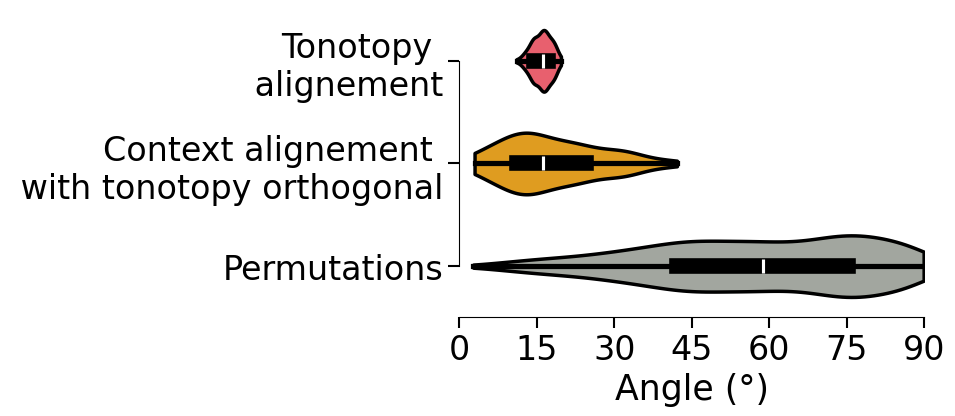

In [535]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def violinplots(data_list, y_labels=("Tonotopy \n alignement","Context alignement \n with tonotopy orthogonal", "Permutations"),
                         x_label="Angle (°)", palette=("#FF495C", 'orange',"#A2A79E"),
                         figsize=(6,4)):

    # Tidy DataFrame for seaborn
    vals = np.concatenate([np.asarray(list_i, float) for list_i in data_list])
    groups = np.repeat(y_labels, [len(list_i) for list_i in data_list])
    df = pd.DataFrame({"Group": groups, "Value": vals})

    fig, ax = plt.subplots(figsize=figsize)

    # Notched (“conic”) boxplots
    sns.violinplot(data=df, x="Value", y="Group", ax=ax, width=0.6, palette=palette,linecolor='black',
                linewidth=2.5,cut=0,inner="box",bw_adjust=1,orient='h')

    # Labels and cosmetics
    ax.set_xlabel(x_label)
    ax.set_xlim(0, 90)
    ax.set_xticks([0, 15, 30, 45, 60, 75, 90])
    ax.set_ylabel("")
    sns.despine(ax=ax, trim=True)
    
    return fig, ax

violinplots([tonotopy_alignement,ctx_n2,alignement_permu])
ax.set_xlim(0, 90)

plt.savefig('Plots/SVG/tonotopy_geometry.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/tonotopy_geometry.PNG', dpi = 300,bbox_inches='tight')

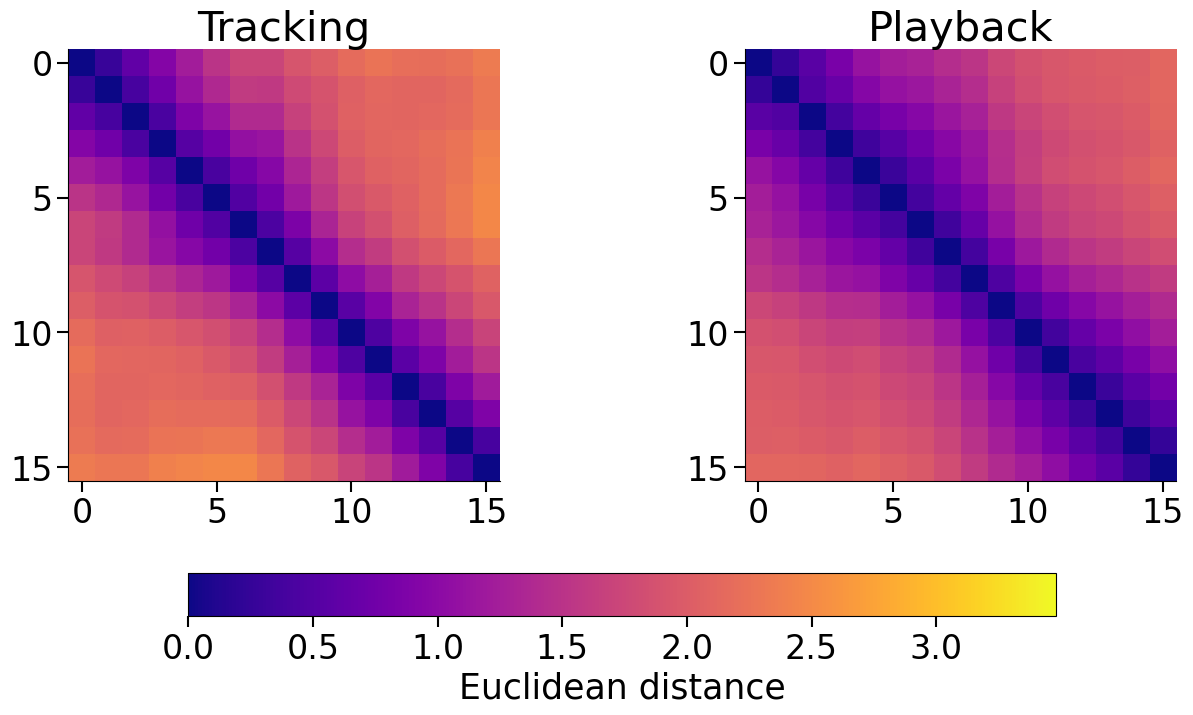

In [404]:
def pairwise_distance(X):
    "X is n_sample times n_features"
    diff = X[:, None, :] - X[None, :, :] 
    D = np.sqrt(np.sum(diff ** 2, axis=-1))
    return D

# --- distance matrices ---
D_track = pairwise_distance(traj_PC_track[:, -1, :])
D_pb    = pairwise_distance(traj_PC_pb[:,   -1, :])

# global colour scale: min & max across BOTH matrices
vmin, vmax = np.min([D_track.min(), D_pb.min()]), np.max([D_track.max(), D_pb.max()])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax+1)   # shared normalisation

# --- plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

im0 = axs[0].imshow(D_track, norm=norm, cmap='plasma')
im1 = axs[1].imshow(D_pb,    norm=norm, cmap='plasma')

axs[0].set_title('Tracking')
axs[1].set_title('Playback')

# single colour-bar for both panels
fig.colorbar(im0, ax=axs.ravel().tolist(), shrink=0.7,orientation='horizontal', location='bottom',label='Euclidean distance')

plt.show()

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/991154088.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Condition', y='Distance',


<Axes: ylabel='Pairwise distance'>

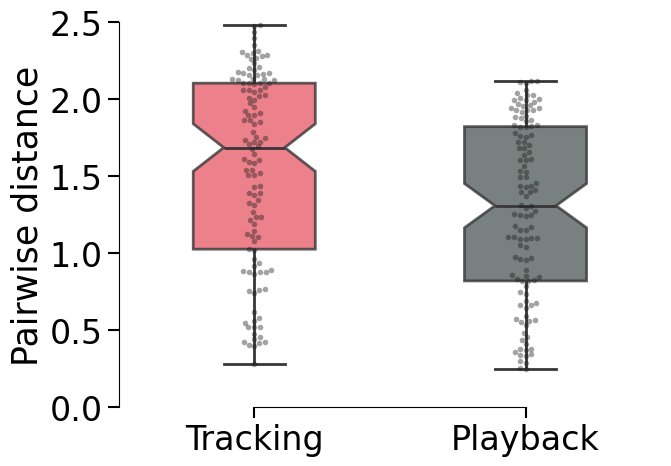

In [872]:
import matplotlib.pyplot as plt
import seaborn as sns

def boxplot_upper_triangles(D1, D2,
                             labels=("Matrix 1", "Matrix 2"),
                             palette=('#FF495C', '#546460'),
                             swarm_alpha=.4,
                             ax=None):
    """
    Prettier comparison of the upper-triangle coefficients of two
    distance matrices: notched box + swarm overlay.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    # ---------- extract upper triangles ----------
    iu = np.triu_indices_from(D1, k=1)
    vals1, vals2 = D1[iu], D2[iu]

    # ---------- tidy DataFrame for seaborn ----------
    df = (pd.DataFrame({
            'Condition': np.repeat(labels, [len(vals1), len(vals2)]),
            'Distance':  np.concatenate([vals1, vals2])
          })
          .reset_index(drop=True))

    # ---------- figure / axes ----------
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # ---------- style ----------
    #sns.set_theme(style="whitegrid", font_scale=1.2)
    #sns.set_theme() 
    sns.boxplot(data=df, x='Condition', y='Distance',
                palette=palette,
                width=.45,
                notch=True,
                linewidth=2,
                fliersize=0,                # hide default outliers
                boxprops=dict(alpha=.8))
    sns.swarmplot(data=df, x='Condition', y='Distance',
                  color='k', alpha=swarm_alpha, size=4)

    # ---------- axes extras ----------
    ax.set_ylabel("Pairwise distance")
    ax.set_xlabel("")
    ax.set_ylim(0, 2.5)
    sns.despine(trim=True)
    return ax

boxplot_upper_triangles(D_track, D_pb, labels=("Tracking", "Playback"))

#plt.savefig('Plots/SVG/dist_tonotopy.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/dist_tonotopy.PNG', dpi = 300,bbox_inches='tight')

In [ ]:
iu = np.triu_indices_from(D_track, k=1)
vals1, vals2 = D_track[iu], D_pb[iu]

mannwhitneyu(vals1,vals2)

#### Animations

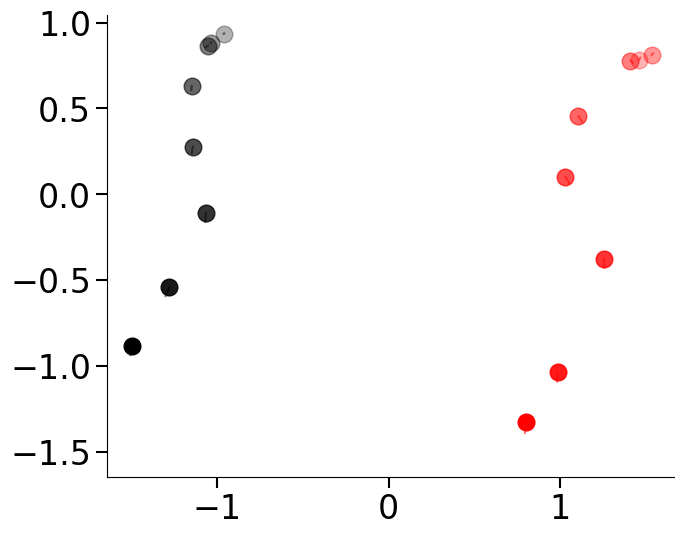

In [106]:
import matplotlib.animation as animation
from IPython.display import HTML

def animate_trajectories(trajectories, colors, interval=50, trail_length=10):
    """
    Create an animation of synchronized trajectories.

    Parameters:
        trajectories (list of np.ndarray): List of arrays of shape [T, D] (2D or 3D).
        colors (list of RGB tuples): Colors for each trajectory (same length as trajectories).
        interval (int): Milliseconds between frames.
        trail_length (int): Number of trailing points to show.

    Returns:
        anim: matplotlib.animation.FuncAnimation object.
    """
    T = min([traj.shape[0] for traj in trajectories])
    D = trajectories[0].shape[1]
    assert D in (2, 3), "Only 2D or 3D trajectories are supported."
    assert len(colors) == len(trajectories), "Colors and trajectories must match."

    fig, ax = plt.subplots(figsize=(8,6))
    ax.set_aspect('equal')

    # Auto-scale based on all data
    all_data = np.vstack(trajectories)
    ax.set_xlim(all_data[:, 0].min() -.1, all_data[:, 0].max()+.1)
    ax.set_ylim(all_data[:, 1].min() - .1, all_data[:, 1].max() + .1)

    dots = [ax.plot([], [], 'o', color=c, markersize=12)[0] for c in colors]
    trails = [ax.plot([], [], '-', color=c, alpha=0.5)[0] for c in colors]

    def init():
        for dot, trail in zip(dots, trails):
            dot.set_data([], [])
            trail.set_data([], [])
        return dots + trails

    def update(frame):
        for i, traj in enumerate(trajectories):
            dot = dots[i]
            trail = trails[i]
            x, y = traj[frame, :2]

            dot.set_data([x], [y])

            start = max(0, frame - trail_length)
            trail.set_data(traj[start:frame+1, 0], traj[start:frame+1, 1])

        return dots + trails

    anim = animation.FuncAnimation(
        fig, update, init_func=init, frames=T, interval=interval, blit=True
    )
    return anim

ani = animate_trajectories(np.concatenate((traj_PC_track[::2],traj_PC_pb[::2]),axis=0),\
                           [(1,0,0,0.3+0.1*i) for i in range(8)]+[(0,0,0,0.3+0.1*i) for i in range(8)])
HTML(ani.to_jshtml())

### Frequency change decoding

In [7]:
np.random.seed(42)

w_size_decoding = 100
n_samples = 300
Xs, Ys = [], []

def sample_events(n_data, triggers, freq, n_samples, w_size):
    """Get sampled event indices, frequencies, and stacked neural data."""
    event_idx = get_event_vicinity(triggers, w_size)
    sampled_idx = np.random.choice(len(event_idx), n_samples, replace=False)
    event_idx = event_idx[sampled_idx]
    event_freq = freq[event_idx[:, w_size - 1]]
    stacked_data = np.stack([n_data[:, idx] for idx in event_idx])
    return event_freq, stacked_data

for n_data, f_data in zip(n_data_s, f_data_s):
    freq = f_data['Played_frequency'].to_numpy()
    direc = f_data['Change_direction'].to_numpy()
    triggers = f_data['Frequency_changes'].to_numpy()
    condition = f_data['Condition'].to_numpy()

    trigger_map = {
        ('track', +1): triggers * (condition == 0) * (direc == 1),
        ('track', -1): triggers * (condition == 0) * (direc == -1),
        ('pb',    +1): triggers * (condition == 1) * (direc == 1),
        ('pb',    -1): triggers * (condition == 1) * (direc == -1),
    }

    freqs, data_blocks = [], []
    for (cond, change), trig in trigger_map.items():
        f, d = sample_events(n_data, trig, freq, n_samples, w_size_decoding)
        freqs.append(f)
        data_blocks.append(d)

    # Concatenate data
    Xs.append(np.concatenate(data_blocks, axis=0))

    # Labels
    freq_label = np.concatenate(freqs)
    cond_label = np.concatenate([
        np.full(n_samples * 2, 0),  # track
        np.full(n_samples * 2, 1)   # pb
    ])
    change_label = np.concatenate([
        np.full(n_samples, +1), np.full(n_samples, -1),  # track
        np.full(n_samples, +1), np.full(n_samples, -1)   # pb
    ])
    Ys.append(np.stack((freq_label, change_label, cond_label), axis=1))

X = np.concatenate(Xs, axis=1)
Y = Ys[0]


In [ ]:
with open("Save/PCA_a1", "rb") as fp:   # Unpickling
     pca_all = pickle.load(fp)

In [172]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import RepeatedKFold

def standardize(X) :
    for j in range(X.shape[1]) :
        if np.std(X[:,j]) > 0 :
            X[:,j] = (X[:,j] - np.mean(X[:,j]))/np.std(X[:,j])
        else : 
            X[:,j] = (X[:,j] - np.mean(X[:,j]))

    return X

def fit_C(X,Y) :
    candidate_c = np.logspace(-2,2,num=15)
    scores = []
    for c in candidate_c :
        rkf = RepeatedKFold(n_splits=2, n_repeats=3,random_state=77)
        scores_fold = []
        for train_idx, test_idx in rkf.split(X): # Cross-validation loop
            X_train, X_test = X[train_idx,:], X[test_idx,:]
            Y_train, Y_test = Y[train_idx], Y[test_idx]

            model = SVC(C=c,kernel='linear')
            model.fit(X_train,Y_train)
            scores_fold.append(model.score(X_test,Y_test))

        scores.append(np.mean(scores_fold))

    return candidate_c[np.argmax(scores)]

nb_permu = 10
nb_bootstrap = 20
timestep = 4

track_change_decoding = []
pb_change_decoding = []
for b in tqdm(range(nb_bootstrap)):  # Redrawing from dataset to bootstrap
    boot_idx = np.random.choice(range(len(X)),len(X),replace=True)
    X_b, Y_b = X[boot_idx], Y[boot_idx]

    track_freq_decoding_t = []
    track_change_decoding_t = []
    pb_freq_decoding_t = []
    pb_change_decoding_t = []
    for t in tqdm(range(np.shape(X)[-1]//timestep)) :  # Decoding across each time
        track_idx = (Y_b[:,2] == 0)*(Y_b[:,0]>= 1200)*(Y_b[:,0] <= 5000)
        pb_idx = (Y_b[:,2] == 1)*(Y_b[:,0]>= 1200)*(Y_b[:,0] <= 5000)
    
        rkf = RepeatedKFold(n_splits=2, n_repeats=5, random_state=42)
        
        X_track = standardize(pca_all.transform(np.mean(X_b[track_idx,:,t*timestep:(t+1)*timestep],axis=-1)))
        #X_track = standardize(np.mean(X_b[track_idx,:,t*timestep:(t+1)*timestep],axis=-1))
        Y_track = Y_b[track_idx,:]

        c_track = fit_C(X_track,Y_track[:,1])
        #print(c_track)
        track_freq_scores = []
        track_change_scores = []
        for train_idx, test_idx in rkf.split(X_track): # Cross-validation loop
            X_train_track, X_test_track = X_track[train_idx,:], X_track[test_idx,:]
            Y_train_track, Y_test_track = Y_track[train_idx,:], Y_track[test_idx,:]
            
            #svc_track_freq = SVC(C=1,kernel='linear')
            svc_track_change = SVC(C=c_track,kernel='linear')
    
            #svc_track_freq.fit(X_train_track,Y_train_track[:,0])
            svc_track_change.fit(X_train_track,Y_train_track[:,1])
    
            #score_freq = svc_track_freq.score(X_test_track,Y_test_track[:,0])
            score_change = svc_track_change.score(X_test_track,Y_test_track[:,1])
    
            scores_change_permu = []
            scores_freq_permu = []
            for p in range(nb_permu) : # Correcting for chance with permutation 
                np.random.shuffle(X_train_track)
                #svc_track_freq = SVC(kernel='linear')
                svc_track_change = SVC(C=c_track,kernel='linear')
        
                #svc_track_freq.fit(X_train_track,Y_train_track[:,0])
                svc_track_change.fit(X_train_track,Y_train_track[:,1])
    
                #scores_freq_permu.append(svc_track_freq.score(X_test_track,Y_test_track[:,0]))
                scores_change_permu.append(svc_track_change.score(X_test_track,Y_test_track[:,1]))
            
            #track_freq_scores.append(score_freq - np.nanmedian(scores_freq_permu))
            track_change_scores.append(score_change - np.nanmedian(scores_change_permu))
    
        #track_freq_decoding_t.append(np.mean(track_freq_scores))
        track_change_decoding_t.append(np.mean(track_change_scores))
        
        X_pb = standardize(pca_all.transform(np.mean(X_b[pb_idx,:,t*timestep:(t+1)*timestep],axis=-1)))
        #X_pb = standardize(np.mean(X_b[pb_idx,:,t*timestep:(t+1)*timestep],axis=-1))
        Y_pb = Y_b[pb_idx,:]
        
        c_pb = fit_C(X_pb,Y_pb[:,1])
        #print(c_pb)
        pb_freq_scores = []
        pb_change_scores = []
        for train_idx, test_idx in rkf.split(X_pb): # Same process for playback condition
            X_train_pb, X_test_pb = X_pb[train_idx,:], X_pb[test_idx,:]
            Y_train_pb, Y_test_pb = Y_pb[train_idx,:], Y_pb[test_idx,:]
            
            #svc_pb_freq = SVC(C=1,kernel='linear')
            svc_pb_change = SVC(C=c_pb,kernel='linear')
    
            #svc_pb_freq.fit(X_train_pb,Y_train_pb[:,0])
            svc_pb_change.fit(X_train_pb,Y_train_pb[:,1])
    
            #score_freq = svc_pb_freq.score(X_test_pb,Y_test_pb[:,0])
            score_change = svc_pb_change.score(X_test_pb,Y_test_pb[:,1])
            
            scores_change_permu = []
            scores_freq_permu = []
            for p in range(nb_permu) :
                np.random.shuffle(X_train_pb)
                #svc_pb_freq = SVC(kernel='linear')
                svc_pb_change = SVC(C=c_pb,kernel='linear')
    
                
                #svc_pb_freq.fit(X_train_pb,Y_train_pb[:,0])
                svc_pb_change.fit(X_train_pb,Y_train_pb[:,1])
    
                #scores_freq_permu.append(svc_pb_freq.score(X_test_pb,Y_test_pb[:,0]))
                scores_change_permu.append(svc_pb_change.score(X_test_pb,Y_test_pb[:,1]))
            
            #pb_freq_scores.append(score_freq - np.nanmedian(scores_freq_permu))
            pb_change_scores.append(score_change - np.nanmedian(scores_change_permu))
    
        #pb_freq_decoding_t.append(np.mean(pb_freq_scores))
        pb_change_decoding_t.append(np.mean(pb_change_scores))

    track_change_decoding.append(track_change_decoding_t)
    pb_change_decoding.append(pb_change_decoding_t)

    
track_change_decoding = np.array(track_change_decoding)
pb_change_decoding = np.array(pb_change_decoding)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

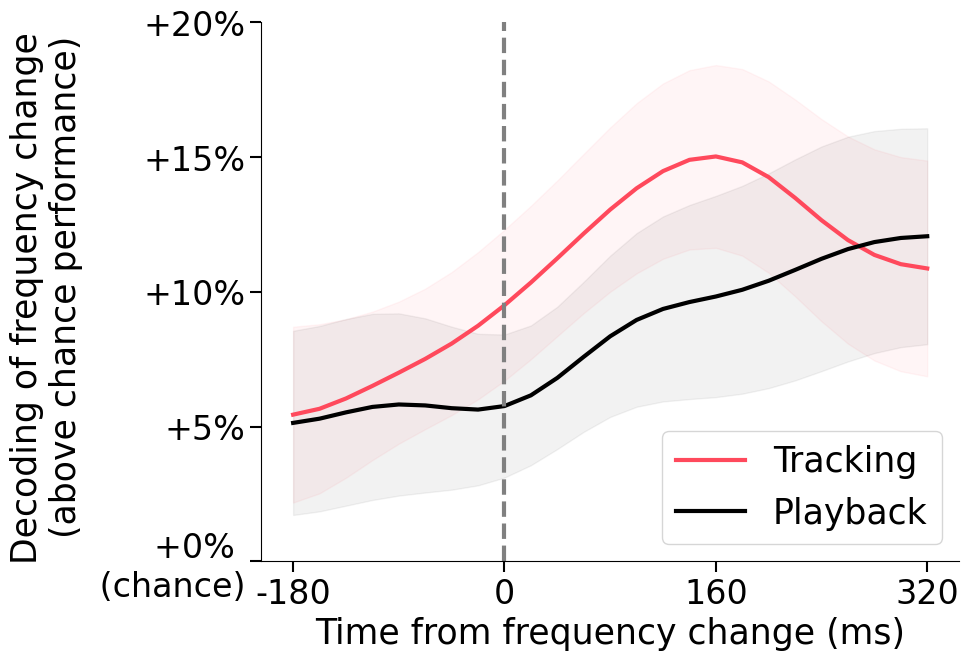

In [450]:
fig = plt.figure(figsize=(9,7))

"""
track_CI_up, track_CI_down = np.percentile(track_change_decoding,(95,5),axis=0)
pb_CI_up, pb_CI_down = np.percentile(pb_change_decoding,(95,5),axis=0)
diff_CI_up, diff_CI_down = np.percentile(track_change_decoding-pb_change_decoding,(95,5),axis=0)
"""

track_CI_up, track_CI_down = np.mean(track_change_decoding,axis=0) + np.std(track_change_decoding,axis=0), np.mean(track_change_decoding,axis=0) - np.std(track_change_decoding,axis=0)
pb_CI_up, pb_CI_down = np.mean(pb_change_decoding,axis=0) + np.std(pb_change_decoding,axis=0), np.mean(pb_change_decoding,axis=0) - np.std(pb_change_decoding,axis=0)
diff = track_change_decoding - pb_change_decoding
diff_CI_up, diff_CI_down = np.mean(diff,axis=0) + np.std(diff,axis=0), np.mean(diff,axis=0) - np.std(diff,axis=0)

sgm=2
plt.plot(gaussian_filter(np.mean(track_change_decoding,axis=0),sigma=sgm),color='#FF495C',linewidth=3,label='Tracking')
plt.plot(gaussian_filter(np.mean(pb_change_decoding,axis=0),sigma=sgm),color='black',linewidth=3,label='Playback')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(track_CI_down,sigma=sgm), gaussian_filter(track_CI_up,sigma=sgm), alpha=0.05, color='#FF495C')
plt.fill_between(range(w_size_decoding//timestep), gaussian_filter(pb_CI_down,sigma=sgm), gaussian_filter(pb_CI_up,sigma=sgm), alpha=0.05, color='black')
#axs[1].plot(gaussian_filter(np.mean(track_change_decoding,axis=0) - np.mean(pb_change_decoding,axis=0),sigma=sgm),color='blue')
#axs[1].fill_between(range(w_size_decoding//timestep), gaussian_filter(diff_CI_down,sigma=sgm), gaussian_filter(diff_CI_up,sigma=sgm), alpha=0.05, color='blue')

plt.axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey',linewidth=3)
#axs[1].axvline(w_size_decoding//(3*timestep),linestyle='--',color='grey')

plt.ylim(0,0.2)
plt.ylabel('Decoding of frequency change \n (above chance performance)')
plt.yticks([0,0.05,0.1,0.15,0.2],['+0% \n (chance)','+5%','+10%','+15%','+20%'])

plt.xlabel('Time from frequency change (ms)')
plt.xticks([0,w_size_decoding//(3*timestep),2*w_size_decoding//(3*timestep),w_size_decoding//timestep-1],np.array([(k-1)*w_size_decoding//(3*timestep) for k in range(4)])*5*timestep)
#axs[1].set_ylim(-0.02,0.12)
#axs[1].set_yticks([0,0.02,0.04,0.06,0.08,0.1],['0%','2%','4%','6%','8%','10%'])

plt.legend()

plt.savefig('Plots/SVG/freq_change_decoding.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/freq_change_decoding.PNG', dpi = 300,bbox_inches='tight')

In [183]:
from scipy.stats import mannwhitneyu

for t in range(np.shape(track_change_decoding)[1]) :
    print(mannwhitneyu(track_change_decoding[:,t],pb_change_decoding[:,t]))

MannwhitneyuResult(statistic=201.0, pvalue=0.9892089047911196)
MannwhitneyuResult(statistic=192.0, pvalue=0.8392322130718609)
MannwhitneyuResult(statistic=211.0, pvalue=0.7763905055505131)
MannwhitneyuResult(statistic=228.0, pvalue=0.4569506196695641)
MannwhitneyuResult(statistic=233.0, pvalue=0.379331935127312)
MannwhitneyuResult(statistic=236.0, pvalue=0.33691523838231996)
MannwhitneyuResult(statistic=284.0, pvalue=0.023903145867558408)
MannwhitneyuResult(statistic=306.0, pvalue=0.0043201840403311225)
MannwhitneyuResult(statistic=352.0, pvalue=4.1657603512605794e-05)
MannwhitneyuResult(statistic=366.0, pvalue=7.577381059726264e-06)
MannwhitneyuResult(statistic=345.0, pvalue=9.277956784594504e-05)
MannwhitneyuResult(statistic=346.0, pvalue=8.292416774489331e-05)
MannwhitneyuResult(statistic=358.0, pvalue=2.0407139096244572e-05)
MannwhitneyuResult(statistic=331.0, pvalue=0.00041550215250851585)
MannwhitneyuResult(statistic=321.0, pvalue=0.0011159472351770113)
MannwhitneyuResult(statist

## Analysis PMC

In [624]:
os.chdir('/Volumes/LaCie')

files_hercule_pmc =['HERCULE_20250528_SESSION_01','HERCULE_20250602_SESSION_00',\
       'HERCULE_20250603_SESSION_01','HERCULE_20250604_SESSION_00',\
      'HERCULE_20250604_SESSION_01','HERCULE_20250605_SESSION_00',\
      'HERCULE_20250605_SESSION_01','HERCULE_20250606_SESSION_00',\
      'HERCULE_20250612_SESSION_00',\
      'HERCULE_20250612_SESSION_02','HERCULE_20250616_SESSION_01']

for i in range(len(files_hercule_pmc)) :
    files_hercule_pmc[i]='HERCULE/' + files_hercule_pmc[i]

files_pmc = files_hercule_pmc

n_data_pmc_s = []
f_data_pmc_s = []
for file in tqdm(files_pmc) :
    n_data = np.load(file+'/headstage_1/data_0.005.npy')
    f_data = np.load(file+'/headstage_1/features_0.005.npy',allow_pickle=True)
    
    
    f_data_dict = {'Played_frequency':[],'Condition':[],'Block':[],'Frequency_changes':[],'Mock_frequency':[],'Mock_change':[]}

    for item in f_data:
        for key, value in item.items():
            f_data_dict[key].append(value)

    f_data = pd.DataFrame(f_data_dict)
    f_data['Change_direction'] = compare_diff(f_data['Played_frequency'].to_numpy())
    f_data['Mock_direction'] = compare_diff(f_data['Mock_frequency'].to_numpy())

    n_data=n_data.astype(float)

    n_data_pmc_s.append(n_data)
    f_data_pmc_s.append(f_data)
    

os.chdir('/Users/hugot/Documents/PHD/Felicie')

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
c=0
for data in n_data_pmc_s :
    c+= np.shape(data)[0]
print(c)

352


In [625]:
from scipy.ndimage import gaussian_filter

for i in tqdm(range(len(n_data_pmc_s))) :
    n_data_smooth = gaussian_filter(n_data_pmc_s[i],sigma=10,axes=1)
    n_data_pmc_s[i] = n_data_smooth

  0%|          | 0/11 [00:00<?, ?it/s]

In [626]:
with open("Save/hercule_pmc", "wb") as fp:   #Pickling
    pickle.dump(n_data_pmc_s, fp)

with open("Save/hercule_pmc_features", "wb") as fp:   #Pickling
    pickle.dump(f_data_pmc_s, fp)

In [842]:
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)

with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

with open("Save/hercule_pmc_features", "rb") as fp:
     f_data_pmc_s = pickle.load(fp)

### Trajectories

In [ ]:
f_min, f_max = 600, 6000
all_traj_track_p, all_traj_track_m = [], []
all_traj_pb_p, all_traj_pb_m = [], []

def process_traj(n_data, event_idx, event_freq):
    """Compute and filter mean trajectories."""
    m_traj = compute_mean_trajectories(n_data.T, event_idx, event_freq)
    return {k: v for k, v in m_traj.items() if f_min <= k <= f_max}

for n_data, f_data in zip(n_data_pmc_s, f_data_pmc_s):
    direc       = f_data['Change_direction'].to_numpy()
    mock_direc  = f_data['Mock_direction'].to_numpy()
    freq        = f_data['Played_frequency'].to_numpy()
    mock        = f_data['Mock_frequency'].to_numpy()
    triggers    = f_data['Frequency_changes'].to_numpy()
    triggers_mock = f_data['Mock_change'].to_numpy()
    condition   = f_data['Condition'].to_numpy()

    trigger_map = {
        'track_p': (triggers * (condition == 0) * (direc == 1),  freq),
        'track_m': (triggers * (condition == 0) * (direc == -1), freq),
        'pb_p':    (triggers_mock * (condition == 1) * (mock_direc == 1),  mock),
        'pb_m':    (triggers_mock * (condition == 1) * (mock_direc == -1), mock),
    }

    results = {}
    for key, (trig, arr) in trigger_map.items():
        event_idx = get_event_vicinity(trig, w_size)
        event_freq = arr[event_idx[:, w_size - 1]]
        results[key] = process_traj(n_data, event_idx, event_freq)

    all_traj_track_p.append(results['track_p'])
    all_traj_track_m.append(results['track_m'])
    all_traj_pb_p.append(results['pb_p'])
    all_traj_pb_m.append(results['pb_m'])


In [781]:
traj_df_track_p, traj_df_track_m = pseudo_trajectories(all_traj_track_p), pseudo_trajectories(all_traj_track_m)
traj_df_pb_p, traj_df_pb_m = pseudo_trajectories(all_traj_pb_p), pseudo_trajectories(all_traj_pb_m)

In [782]:
from sklearn.decomposition import PCA
import numpy as np

# Stack and combine trajectory matrices
traj_mats = [
    np.stack(traj_df_track_p['trajectory']),
    np.stack(traj_df_track_m['trajectory']),
    np.stack(traj_df_pb_p['trajectory']),
    np.stack(traj_df_pb_m['trajectory']),
    # np.stack(traj_df_pb_mock['trajectory'])  # optional
]
traj_mat_all = np.concatenate(traj_mats, axis=0)

# Flatten for PCA
n_trials, n_time, n_features = traj_mat_all.shape
traj_mat_flat = traj_mat_all.reshape(n_trials * n_time, n_features)

# PCA
n_comp = 10
pca_all = PCA(n_components=n_comp)
traj_PC_all_flat = pca_all.fit_transform(traj_mat_flat)

# Reshape back to (trial, time, components)
traj_PC_all = traj_PC_all_flat.reshape(n_trials, n_time, n_comp)

# Split results back into groups
nb_freq = traj_mats[0].shape[0]
traj_PC_track_p, traj_PC_track_m, traj_PC_pb_p, traj_PC_pb_m = [
    traj_PC_all[i * nb_freq:(i + 1) * nb_freq] for i in range(len(traj_mats))
]



In [800]:
with open("Save/PCA_pmc_widefreq", "wb") as fp:   #Pickling
    pickle.dump(pca_all, fp)

#### Reproducing A1 plots

Text(0, 0.5, 'PC2')

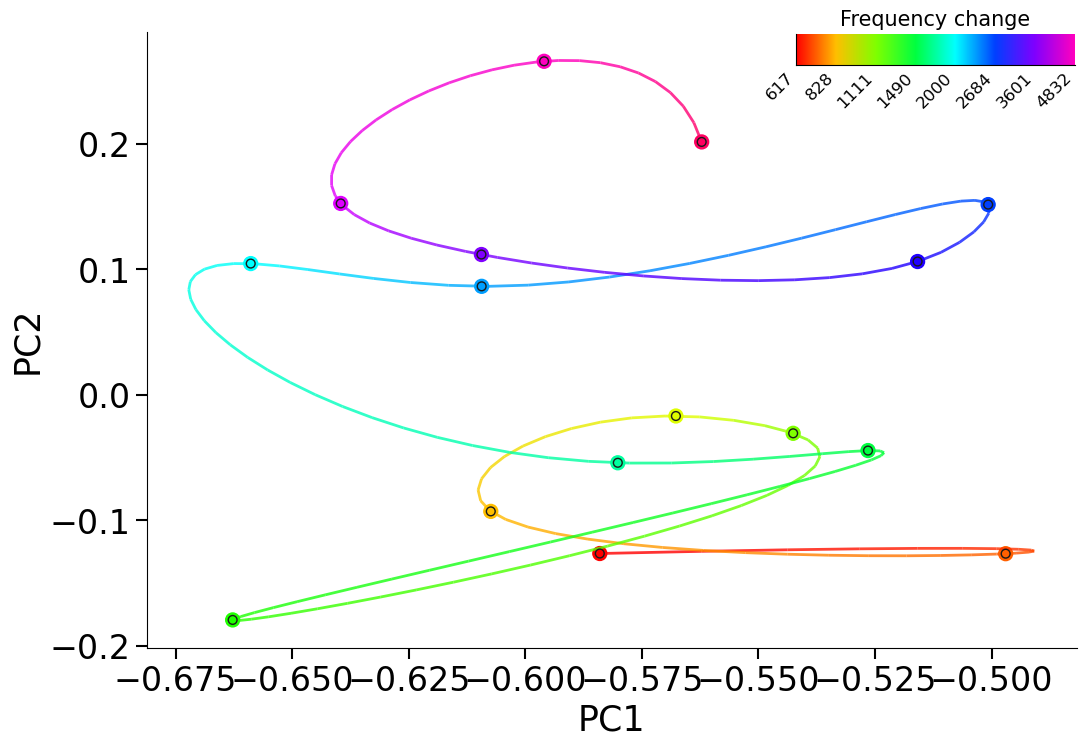

In [824]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)

traj_toplot = traj_PC_pb_m

nb_times = len(traj_toplot[0])

start_time = int(nb_times*0.2)
stop_time = int(nb_times*0.9)

"""
for i in range(len(traj_toplot)) :
    draw_traj(traj_toplot[i][start_time:stop_time,:2],ax,cmaps[i])
"""
    
colors = get_hsv_colors(len(traj_toplot))



ax.scatter(traj_toplot[:,stop_time,0],traj_toplot[:,stop_time,1],c=colors,s=100)
#ax.scatter(traj_PC_pb[:,-1,1],traj_PC_pb[:,-1,2],c=colors,s=100)
add_inset_phase_legend(ax, colors[::2],tick_labels=traj_df_track_p['label'].to_numpy().astype(int)[::2])
plot_gradient_curve(traj_toplot[:,stop_time,:2],colors, ax)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#plt.savefig('Plots/SVG/tonotopy_traj_tracking_-_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_traj_tracking_-_hstage1.PNG', dpi = 300,bbox_inches='tight')

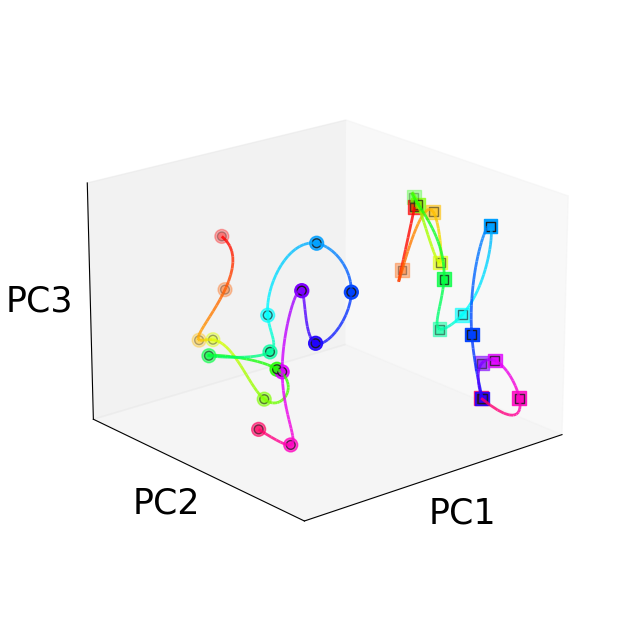

In [839]:
from scipy.interpolate import splprep, splev

cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()

traj_toplot1 = (traj_PC_track_p + traj_PC_track_m)/2
traj_toplot2 = (traj_PC_pb_p + traj_PC_pb_m)/2

ax.scatter(traj_toplot1[:,-1,0],traj_toplot1[:,-1,1],traj_toplot1[:,-1,2],c=colors,s=100)
plot_gradient_curve(traj_toplot1[:,-1,:3],colors, ax)

ax.scatter(traj_toplot2[:,-1,0],traj_toplot2[:,-1,1],traj_toplot2[:,-1,2],c=colors,s=100,marker='s')
plot_gradient_curve(traj_toplot2[:,-1,:3],colors, ax,marker='s')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=50, elev=20)

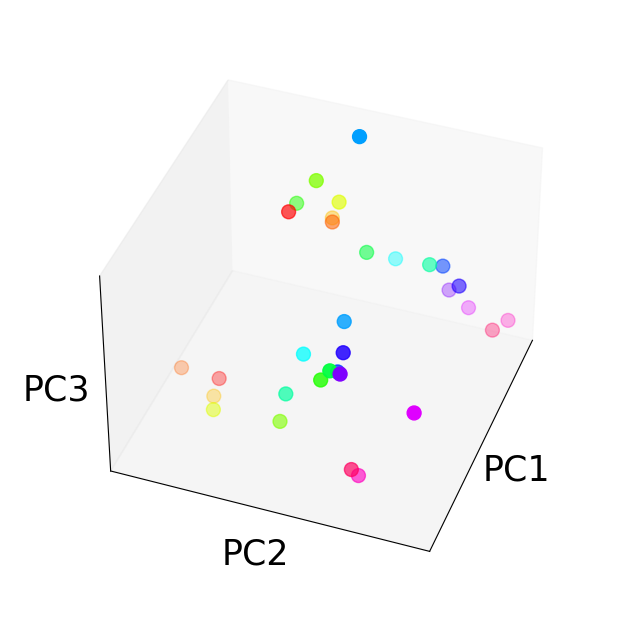

In [618]:
cmaps = create_white_to_color_colormaps(n_colors=16)

fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
colors = get_hsv_colors()


ax.scatter(traj_PC_track_pmc[:,-1,0],traj_PC_track_pmc[:,-1,1],traj_PC_track_pmc[:,-1,2],c=colors,s=100)
ax.scatter(traj_PC_pb_pmc[:,-1,0],traj_PC_pb_pmc[:,-1,1],traj_PC_pb_pmc[:,-1,2],c=colors,s=100)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.85)
ax.view_init(azim=20, elev=40)
#plt.savefig('Plots/SVG/tonotopy_comparison_hstage1.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/tonotopy_comparison_hstage1.png', dpi = 300,bbox_inches='tight')

### Cross-correlation

In [273]:
def extract_cuts(index_list, data_array, min_length=1000):
    """
    Extracts cuts from a 2D array based on regions where values in the index_list
    are consistently 0 or 1 for more than min_length points.

    Parameters:
    - index_list: List[int] with values -1, 0, 1.
    - data_array: np.ndarray, 2D array with shape (N, M), M == len(index_list).
    - min_length: int, minimum length for a segment to be considered a valid cut.

    Returns:
    - cuts_0: List of np.ndarrays where index == 0 for > min_length.
    - cuts_1: List of np.ndarrays where index == 1 for > min_length.
    """
    index_array = np.array(index_list)
    assert data_array.shape[1] == len(index_list), "Data column count must match index list length."

    cuts_0 = []
    cuts_1 = []

    current_val = None
    start_idx = 0

    for i, val in enumerate(index_array):
        if val != current_val:
            if current_val in (0, 1):
                segment_length = i - start_idx
                if segment_length > min_length:
                    segment = data_array[:, start_idx:i]
                    if current_val == 0:
                        cuts_0.append(segment)
                    elif current_val == 1:
                        cuts_1.append(segment)
            start_idx = i
            current_val = val

    # Handle last segment
    if current_val in (0, 1):
        segment_length = len(index_array) - start_idx
        if segment_length > min_length:
            segment = data_array[:, start_idx:]
            if current_val == 0:
                cuts_0.append(segment)
            elif current_val == 1:
                cuts_1.append(segment)

    return [cuts_0, cuts_1]

cond_slice_a1 = [extract_cuts(f_data_s[i]['Condition'].to_numpy(),n_data_a1_s[i]) for i in range(len(f_data_s))]
cond_slice_pmc = [extract_cuts(f_data_pmc_s[i]['Condition'].to_numpy(),n_data_pmc_s[i]) for i in range(len(f_data_s))]

Text(0.5, 0, 'Time')

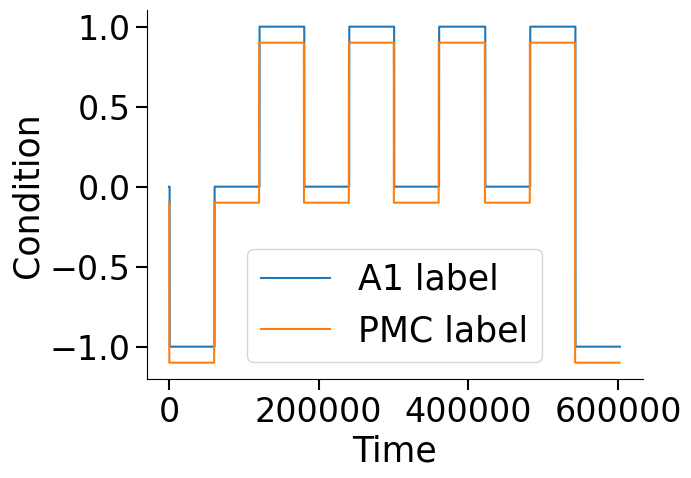

In [277]:
plt.plot(f_data_s[9]['Condition'],label='A1 label')
plt.plot(f_data_pmc_s[9]['Condition'] - 0.1,label='PMC label')

plt.legend()
plt.ylabel('Condition')
plt.xlabel('Time')

In [67]:
for i in range(len(n_data_pmc_s)) :
    print(np.shape(cond_slice_a1[i][0][0]))
    print(np.shape(cond_slice_pmc[i][0][0]))

(26, 361042)
(32, 340347)
(21, 360711)
(32, 339356)
(20, 360663)
(32, 303149)
(21, 361378)
(32, 301846)
(22, 360751)
(32, 252006)
(25, 360876)
(32, 302394)
(27, 360707)
(32, 245630)
(14, 59995)
(32, 315180)
(17, 59952)
(32, 60002)
(22, 59385)
(32, 60078)
(24, 12772)
(32, 60322)


In [274]:
import numpy as np

def pairwise_correlations(array1, array2):
    """
    Compute all pairwise Pearson correlations between neurons in two 2D arrays.

    Parameters:
    - array1: np.ndarray of shape (N1, T) where N1 is number of neurons, T is number of time points
    - array2: np.ndarray of shape (N2, T)

    Returns:
    - correlation_matrix: np.ndarray of shape (N1, N2) with correlation coefficients
    """
    if not array1.shape[1] == array2.shape[1] :
        print("Slightly different shape truncating to match time points..  /n Array 1 shape: " + str(array1.shape[1]) + '//' + 'Array 2 shape: ' + str(array2.shape[1]))
        min_shape = np.minimum(array1.shape[1],array2.shape[1])
        array1 = array1[:,:min_shape]
        array2 = array2[:,:min_shape]
    # Normalize both arrays (zero mean, unit variance)
    a1 = (array1 - array1.mean(axis=1, keepdims=True)) / array1.std(axis=1, keepdims=True)
    a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)

    # Compute correlation matrix using matrix multiplication
    correlation_matrix = np.dot(a1, a2.T) / array1.shape[1]

    return np.nan_to_num(correlation_matrix)


corr_tracking = []
corr_playback = []
for session_id in range(len(cond_slice_a1)) :
    tracking_a1 = cond_slice_a1[session_id][0]
    tracking_pmc = cond_slice_pmc[session_id][0]

    playback_a1 = cond_slice_a1[session_id][1]
    playback_pmc = cond_slice_pmc[session_id][1]

    for i in range(len(tracking_a1)) :
        corr_tracking.append(pairwise_correlations(tracking_a1[i],tracking_pmc[i]).flatten())
        
    for i in range(len(playback_a1)) :
        corr_playback.append(pairwise_correlations(playback_a1[i],playback_pmc[i]).flatten())

Slightly different shape truncating to match time points..  /n Array 1 shape: 339355//Array 2 shape: 339356
Slightly different shape truncating to match time points..  /n Array 1 shape: 249089//Array 2 shape: 250781
Slightly different shape truncating to match time points..  /n Array 1 shape: 298730//Array 2 shape: 298729
Slightly different shape truncating to match time points..  /n Array 1 shape: 60061//Array 2 shape: 60062
Slightly different shape truncating to match time points..  /n Array 1 shape: 59880//Array 2 shape: 59879


/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/823023146.py:21: RuntimeWarning: invalid value encountered in divide
  a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)


In [284]:
mean_corr_track.shape

(6016,)

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/2767500610.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(df_plot[::20], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=6,alpha=0.5)


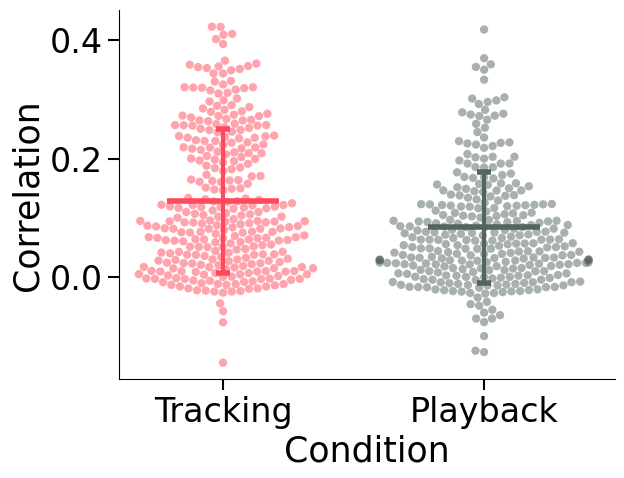

In [443]:
"""
mean_corr_track = [np.mean(corr_tracking[i]) for i in range(len(corr_tracking))]
mean_corr_pb = [np.mean(corr_playback[i]) for i in range(len(corr_playback))]
"""

mean_corr_track = np.concatenate(corr_tracking)
mean_corr_pb = np.concatenate(corr_playback)

df_plot = pd.DataFrame({'Correlation':np.concatenate((mean_corr_track,mean_corr_pb)), \
'Condition':['Tracking']*len(mean_corr_track)+['Playback']*len(mean_corr_pb)})

#sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#FF495C','#546460'],inner_kws={'box_width':15},cut=3,bw_adjust=1)
sns.swarmplot(df_plot[::20], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=6,alpha=0.5)
plt.errorbar(0,np.mean(mean_corr_track),yerr=np.std(mean_corr_track),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#FF495C')
plt.errorbar(1,np.mean(mean_corr_pb),yerr=np.std(mean_corr_pb),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#546460')
plt.xlim((-0.4,1.5))

plt.savefig('Plots/SVG/pairwise_corr.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/pairwise_corr.PNG', dpi = 300,bbox_inches='tight')

In [314]:
from scipy.stats import mannwhitneyu

mannwhitneyu(mean_corr_track, mean_corr_pb)

MannwhitneyuResult(statistic=284.0, pvalue=0.023903145867558408)

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/119276385.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#546460','#F0A202','#D95D39','#FF495C'],inner_kws={'box_width':15},cut=3,bw_adjust=1)


<Axes: xlabel='Condition', ylabel='Correlation'>

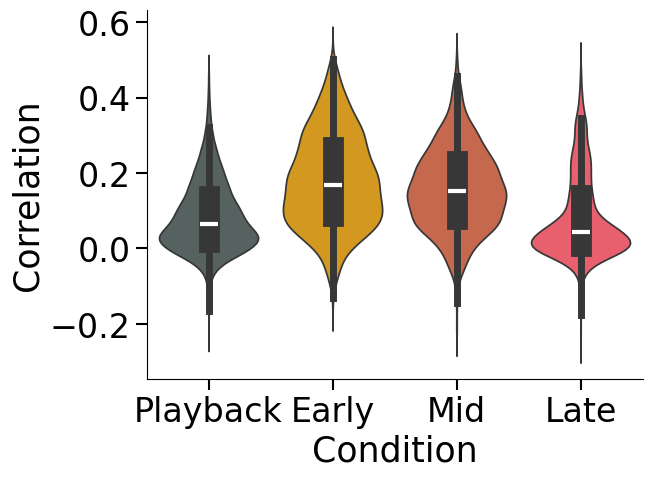

In [277]:
import pandas as pd
import seaborn as sns

corr_early = np.concatenate(corr_tracking[:6])
corr_mid = np.concatenate(corr_tracking[6:12])
corr_late = np.concatenate(corr_tracking[12:])
corr_pb = np.concatenate(corr_playback[:])

df_plot = pd.DataFrame({'Correlation':np.concatenate((corr_pb,corr_early,corr_mid,corr_late)), \
'Condition':['Playback']*len(corr_pb)+['Early']*len(corr_early)+['Mid']*len(corr_mid)+['Late']*len(corr_late)})

sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#546460','#F0A202','#D95D39','#FF495C'],inner_kws={'box_width':15},cut=3,bw_adjust=1)
#plt.plot([np.mean(corr_tracking[i]) for i in range(len(corr_tracking))])
#plt.plot([np.mean(corr_playback[i]) for i in range(len(corr_playback))])

## CCA

In [801]:
"""
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)
"""
with open("Save/h&n_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/h&n_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)

with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

with open("Save/hercule_pmc_features", "rb") as fp:
     f_data_pmc_s = pickle.load(fp)

In [846]:
w_size_cca = 100

fmin = 1500
fmax = 4000

def slice_data(n_data_sessions, f_data_sessions) :
    Xs = []
    Ys = []
    for i in range(len(n_data_sessions)) :
        n_data = n_data_sessions[i]
        f_data = f_data_sessions[i]
    
        freq = f_data['Played_frequency'].to_numpy()
        mock = f_data['Mock_frequency'].to_numpy()
        direc = f_data['Change_direction'].to_numpy()
        direc_mock = f_data['Mock_direction'].to_numpy()
        triggers = f_data['Frequency_changes'].to_numpy()
        triggers_mock = f_data['Mock_change'].to_numpy()
        condition = f_data['Condition'].to_numpy()
    
        triggers = triggers*(freq >= fmin)*(freq <= fmax)
        triggers_mock = triggers_mock*(mock >= fmin)*(mock <= fmax)
        
        triggers_track_plus = triggers*(condition==0)*(direc==1)
        triggers_track_minus = triggers*(condition==0)*(direc==-1)
        
        triggers_pb_plus = triggers*(condition==1)*(direc==1)
        triggers_mock_pb_plus = triggers_mock*(condition==1)*(direc_mock==1)
        triggers_pb_minus = triggers*(condition==1)*(direc==-1)
        triggers_mock_pb_minus = triggers_mock*(condition==1)*(direc_mock==-1)
    
        
        event_idx_track_plus = get_event_vicinity(triggers_track_plus, w_size_cca)
        Fevent_freq_track_plus = freq[event_idx_track_plus[:,-1]]
        Fevent_mock_track_plus = mock[event_idx_track_plus[:,-1]]
    
        event_idx_track_minus = get_event_vicinity(triggers_track_minus, w_size_cca)
        Fevent_freq_track_minus = freq[event_idx_track_minus[:,-1]]
        Fevent_mock_track_minus = mock[event_idx_track_minus[:,-1]]
    
        event_idx_pb_plus = get_event_vicinity(triggers_pb_plus, w_size_cca)
        Fevent_freq_pb_plus = freq[event_idx_pb_plus[:,-1]]
        Fevent_mock_pb_plus = mock[event_idx_pb_plus[:,-1]]
    
        event_idx_pb_minus = get_event_vicinity(triggers_pb_minus, w_size_cca)
        Fevent_freq_pb_minus = freq[event_idx_pb_minus[:,-1]]
        Fevent_mock_pb_minus = mock[event_idx_pb_minus[:,-1]]
    
        event_idx_mock_pb_plus = get_event_vicinity(triggers_mock_pb_plus, w_size_cca)
        Mevent_freq_pb_plus = freq[event_idx_mock_pb_plus[:,-1]]
        Mevent_mock_pb_plus = mock[event_idx_mock_pb_plus[:,-1]]
    
        event_idx_mock_pb_minus = get_event_vicinity(triggers_mock_pb_minus, w_size_cca)
        Mevent_freq_pb_minus = freq[event_idx_mock_pb_minus[:,-1]]
        Mevent_mock_pb_minus = mock[event_idx_mock_pb_minus[:,-1]]
    
        n_track_plus = np.stack([n_data[:,event_idx_track_plus[i,:]] for i in range(len(event_idx_track_plus))])
        n_track_minus = np.stack([n_data[:,event_idx_track_minus[i,:]] for i in range(len(event_idx_track_minus))])
    
        n_pb_plus = np.stack([n_data[:,event_idx_pb_plus[i,:]] for i in range(len(event_idx_pb_plus))])
        n_pb_minus = np.stack([n_data[:,event_idx_pb_minus[i,:]] for i in range(len(event_idx_pb_minus))])
    
        n_pb_mock_plus = np.stack([n_data[:,event_idx_mock_pb_plus[i,:]] for i in range(len(event_idx_mock_pb_plus))])
        n_pb_mock_minus = np.stack([n_data[:,event_idx_mock_pb_minus[i,:]] for i in range(len(event_idx_mock_pb_minus))])
        
        Xs.append(np.concatenate((n_track_plus,n_track_minus,n_pb_plus,n_pb_minus,n_pb_mock_plus,n_pb_mock_minus),axis=0))
    
        freq_label = np.concatenate((Fevent_freq_track_plus,Fevent_freq_track_minus,Fevent_freq_pb_plus,Fevent_freq_pb_minus,Mevent_freq_pb_plus,Mevent_freq_pb_minus))
        mock_label = np.concatenate((Fevent_mock_track_plus,Fevent_mock_track_minus,Fevent_mock_pb_plus,Fevent_mock_pb_minus,Mevent_mock_pb_plus,Mevent_mock_pb_minus))
        cond_label = np.concatenate((np.array([0]*(len(Fevent_freq_track_plus) + len(Fevent_freq_track_minus))),\
                                     np.array([1]*(len(Fevent_freq_pb_plus) + len(Fevent_freq_pb_minus) + len(Mevent_freq_pb_plus) + len(Mevent_freq_pb_minus)))))
        Fchange_label = np.concatenate((np.array([1]*len(Fevent_freq_track_plus)), np.array([-1]*len(Fevent_freq_track_minus)),\
                                     np.array([1]*len(Fevent_freq_pb_plus)), np.array([-1]*len(Fevent_freq_pb_minus)), \
                                      np.array([0]*len(Mevent_freq_pb_plus)), np.array([0]*len(Mevent_freq_pb_minus))))
    
        Mchange_label = np.concatenate((np.array([1]*len(Fevent_freq_track_plus)), np.array([-1]*len(Fevent_freq_track_minus)),\
                                     np.array([0]*len(Fevent_freq_pb_plus)), np.array([0]*len(Fevent_freq_pb_minus)), \
                                      np.array([1]*len(Mevent_freq_pb_plus)), np.array([-1]*len(Mevent_freq_pb_minus))))
        
        Ys.append(np.stack((freq_label,mock_label,Fchange_label,Mchange_label,cond_label)).T)

    return Xs, Ys

Xs_a1, Ys_a1 = slice_data(n_data_a1_s, f_data_a1_s) 
Xs_pmc, Ys_pmc = slice_data(n_data_pmc_s, f_data_pmc_s)   

In [847]:
def mean_psth_by_condition(M, F):
    """
    Group trials in M based on context and selected features from F.

    Parameters
    ----------
    M : ndarray, shape (n_trials, ..., n_time)
    F : ndarray, shape (n_trials, 5)
        Columns: freq, mock, freq_change, mock_change, context

    Returns
    -------
    M_mean : ndarray, shape (n_groups, ..., n_time)
    F_group : ndarray, shape (n_groups, n_features_kept)
        Feature combinations for each group.
        First column = context, rest depend on grouping rule.
    """
    M = np.asarray(M)
    F = np.asarray(F)

    if M.shape[0] != F.shape[0]:
        raise ValueError("M and F must have the same number of trials.")

    context = F[:, 4]
    group_keys = []
    group_ids = []

    # Context == 0: freq & freq_change
    mask0 = context == 0
    keys0 = np.stack([context[mask0],
                      F[mask0, 0],  # freq
                      F[mask0, 2]], axis=1)
    group_keys.append(keys0)
    group_ids.append(np.nonzero(mask0)[0])

    # Context == 1: freq & freq_change
    mask1_freq = context == 1
    keys1_freq = np.stack([context[mask1_freq],
                           F[mask1_freq, 0],  # freq
                           F[mask1_freq, 2]], axis=1)
    group_keys.append(keys1_freq)
    group_ids.append(np.nonzero(mask1_freq)[0])

    # Context == 1: mock & mock_change
    mask1_mock = context == 1
    keys1_mock = np.stack([context[mask1_mock],
                           F[mask1_mock, 1],  # mock
                           F[mask1_mock, 3]], axis=1)
    group_keys.append(keys1_mock)
    group_ids.append(np.nonzero(mask1_mock)[0])

    # Combine all
    all_keys = np.vstack(group_keys)
    all_idx = np.concatenate(group_ids)

    # Unique combinations
    unique_keys, inv = np.unique(all_keys, axis=0, return_inverse=True)

    # Mean PSTHs per group
    out_shape = (len(unique_keys),) + M.shape[1:]
    M_mean = np.zeros(out_shape, dtype=M.dtype)
    for i in range(len(unique_keys)):
        M_mean[i] = M[all_idx[inv == i]].mean(axis=0)
        for j in range(len(M_mean[i])) :
            M_mean[i][j] = M_mean[i][j] - M_mean[i][j].mean(axis=0) #Removing cross-condition variations
        
    return M_mean, unique_keys


M_sessions_a1 = [mean_psth_by_condition(Xs_a1[i],Ys_a1[i])[0] for i in range(len(Xs_a1))]
F_sessions_a1 = [mean_psth_by_condition(Xs_a1[i],Ys_a1[i])[1] for i in range(len(Xs_a1))]

M_sessions_pmc = [mean_psth_by_condition(Xs_pmc[i],Ys_pmc[i])[0] for i in range(len(Xs_pmc))]
F_sessions_pmc = [mean_psth_by_condition(Xs_pmc[i],Ys_pmc[i])[1] for i in range(len(Xs_pmc))]

In [849]:
def merge_sessions_pseudo_pop(F_list, M_list):
    """
    Merge reduced F and M from multiple sessions into a pseudo-population.

    Parameters
    ----------
    F_list : list of ndarray
        Each (n_cond_session, n_features) — feature combinations for each session.
    M_list : list of ndarray
        Each (n_cond_session, n_neurons_session, n_time) — mean PSTHs per session.

    Returns
    -------
    M_pseudo : ndarray, shape (n_common, sum_neurons, n_time)
        Pseudo-population PSTHs for combinations present in all sessions.
    F_common : ndarray, shape (n_common, n_features)
        The common feature combinations across all sessions, in consistent order.
    """
    # Convert feature matrices to tuple-rows for set operations
    sets = [set(map(tuple, F)) for F in F_list]

    # Intersection across all sessions
    common_set = set.intersection(*sets)
    if len(common_set) == 0:
        raise ValueError("No common feature combinations found across sessions.")

    # Sort to have consistent order (optional: sort by feature values)
    F_common = np.array(sorted(common_set))

    # Collect aligned M for each session
    M_aligned = []
    for F, M in zip(F_list, M_list):
        # Map feature tuple -> row index
        idx_map = {tuple(row): i for i, row in enumerate(F)}
        # Get indices for F_common in the current session
        idxs = [idx_map[tuple(row)] for row in F_common]
        # Select and append
        M_aligned.append(M[idxs])

    # Concatenate along neuron axis (axis=1)
    M_pseudo = np.concatenate(M_aligned, axis=1)

    return M_pseudo, F_common

def intersection_row_indices(F1, F2):
    """
    Return the indices of rows common to both F1 and F2,
    in the order they appear in each matrix.
    """
    # Convert rows to tuples so they can go in sets/dicts
    rows_F1 = list(map(tuple, F1))
    rows_F2 = list(map(tuple, F2))

    # Find intersection as a set of tuples
    common_rows = set(rows_F1) & set(rows_F2)

    # Indices in each matrix
    idx_F1 = [i for i, r in enumerate(rows_F1) if r in common_rows]
    idx_F2 = [i for i, r in enumerate(rows_F2) if r in common_rows]

    return np.array(idx_F1), np.array(idx_F2)


M_a1, F_a1 = merge_sessions_pseudo_pop(F_sessions_a1,M_sessions_a1)
M_pmc, F_pmc = merge_sessions_pseudo_pop(F_sessions_pmc,M_sessions_pmc)

try :
    print(np.all(F_a1 == F_pmc)) # Sanity check

except :
    print('Not the same condition in both matrices, taking intersection..')
    idx1, idx2 = intersection_row_indices(F_a1, F_pmc)

    M_a1, F_a1 = M_a1[idx1], F_a1[idx1]
    M_pmc, F_pmc = M_pmc[idx2], F_pmc[idx2]

    print(np.all(F_a1 == F_pmc)) 


Not the same condition in both matrices, taking intersection..
True


In [850]:
with open("Save/PCA_a1_widefreq", "rb") as fp:   # Unpickling
     pca_a1 = pickle.load(fp)

with open("Save/PCA_pmc_widefreq", "rb") as fp:   # Unpickling
     pca_pmc = pickle.load(fp)

In [870]:
M_a1_track = M_a1[F_a1[:,2]==0]
M_pmc_track = M_pmc[F_a1[:,2]==0]

M_a1_pb = M_a1[F_a1[:,2]==1]
M_pmc_pb = M_pmc[F_a1[:,2]==1]

A = M_a1_pb
P = M_pmc_pb

A = A.reshape((A.shape[0]*A.shape[2],A.shape[1]))
P = P.reshape((P.shape[0]*P.shape[2],P.shape[1]))

#A = standardize(A)
#P = standardize(P)
A = standardize(pca_a1.transform(A))
P = standardize(pca_pmc.transform(P))

cca = CCA(n_components=5)

cca.fit(A,P)

def compute_CCA_scores(X,Y,cca) :
    scores = []
    for i in range(cca.n_components) :
        x_i = X@cca.x_weights_[:,i]
        y_i = Y@cca.y_weights_[:,i]
        
        scores.append(pearsonr(x_i,y_i)[0])
        
    return np.array(scores)

#compute_CCA_scores(A,P,cca)

A_c, P_c = cca.transform(A, P)  # canonical variates
corrs = [np.corrcoef(A_c[:, i], P_c[:, i])[0, 1] for i in range(cca.n_components)]
print(corrs)

[0.1613328638101941, 0.13116826259172992, 0.10734561985147248, 0.0896371418869028, 0.06377412418818323]


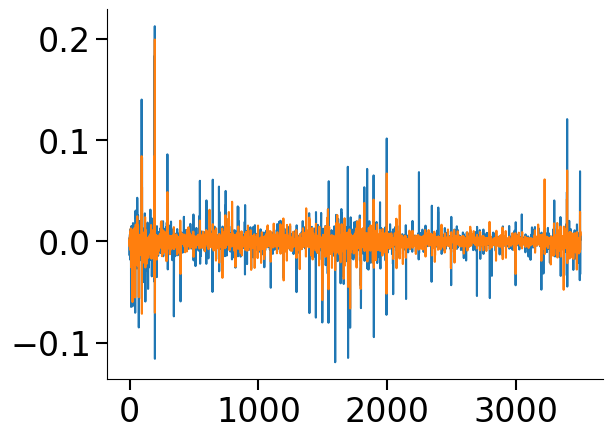

In [755]:
plt.plot(A_c[:,0])
plt.plot(P_c[:,0]*50)

In [ ]:
plt.plot(np.mean((cca.x_weights_.T)**2,axis=0),color='red')
plt.plot(np.mean((cca.y_weights_.T)**2,axis=0),color='orange')

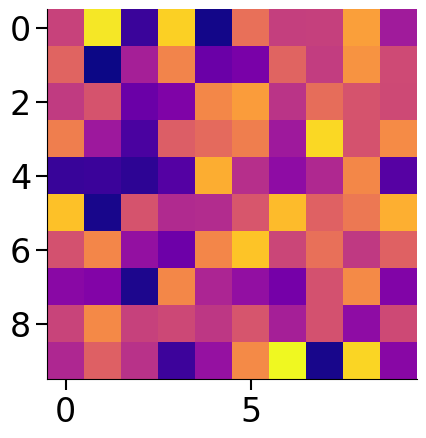

In [871]:
plt.imshow(cca.x_weights_@cca.y_weights_.T,cmap='plasma')